In [11]:
import random
import os
import pycosat

In [12]:
class Generate:
    numberOfClause   = 0
    numberOfVariable = 0
    evidenceLength = 0
    varList = []
    maxClauseLength = 0

    def __init__(self,nClause,nVariable,length,maxNumber):
        print ("Generation aleatoire : ")
        self.numberOfClause = nClause
        self.numberOfVariable = nVariable
        self.evidenceLength = length
        self.maxClauseLength = maxNumber
        for i in range(self.numberOfVariable):
            self.varList.append(i+1)
            self.varList.append(-(i+1))
        print ("  Nembre de clauses = ",nClause)
        print ("  Nembre de variables = ",nVariable)
        print ("  Nembre de evidence = ",length)
        print ("  Nembre max de variables dans une clause = ",maxNumber)
        print ("Initialisation complete.")

    def getEvidence(self):
        return random.sample(self.varList, self.evidenceLength) # on genere une liste d'evidence selon la 
        # taille de evidence lenght et la liste des var

    def generateBC(self):
        #os.system("touch temp.txt") 
        BCFile = open("base_de_connaissance.txt","w")
        for i in range(self.numberOfClause):
            ran = random.randrange(1,self.maxClauseLength + 1,1)
            tempList = random.sample(self.varList, ran)
            weight = random.random()
            weight = float(int(weight*100))/100
            chaine = "" + str(weight)+ " "
            for i in range(len(tempList)):
                chaine = chaine + str(tempList[i]) + " "
            BCFile.write(chaine + "\n")
            tempList=[]
        BCFile.close()


In [13]:
class Process:
    lower = 0
    upper = 0
    weights = []
    formulas = []
    stratesWeights = []
    
    def __init__(self, pathFile):
        file = open(pathFile)
        for line in file:
            information = line.split()
            size = len(information)
            self.weights.append(float(information[0]))
            self.formulas.append([int(information[i]) for i in range(size) if i != 0]) 
        self.length = len(self.weights)
        file.close()
        print("Fin de la génération des poids et des formules.")

    def getLength(self):
        return self.length

    def getWeights(self):
        return self.weights

    def getFormulas(self):
        return self.formulas

    def sortedWeight(self):
        for i in range(len(self.weights)-1, 0, -1):
            for j in range(i):
                if self.weights[j] < self.weights[j+1]:
                    self.weights[j], self.weights[j+1] = self.weights[j+1], self.weights[j]
                    self.formulas[j], self.formulas[j+1] = self.formulas[j+1], self.formulas[j]

    def calculateStrates(self):
        noDouble = set(self.weights)
        self.upper = len(noDouble)
        self.stratesWeights = sorted(noDouble)

    def getStratesNumber(self):
        return self.upper

    def getStratesWeights(self):
        return self.stratesWeights

    def getPreProcessedFormulas(self, subFormulas):
        dictCor = {}
        returnedFormulas = []
        cpt = 1
        i = 0
        for form in subFormulas:
            j = 0
            returnedFormulas.insert(i, [])
            for pred in form:
                if pred not in dictCor.keys():
                    if int(pred) > 0:
                        dictCor[int(pred)] = cpt
                        dictCor[-int(pred)] = -cpt
                        cpt += 1
                    else:
                        dictCor[-int(pred)] = cpt
                        dictCor[int(pred)] = -cpt
                        cpt += 1
                returnedFormulas[i].insert(j, dictCor[pred])
                j += 1
            i += 1
        return returnedFormulas


In [14]:
import pycosat
import random

# Paramètres d'initialisation
nClause = 4
nVariable = 3
length = 2
maxNumber = 3

# Génération de la base de connaissance
gen = Generate(nClause, nVariable, length, maxNumber)
gen.generateBC() 

# Initialisation de la base de connaissance
baseConnaissance = Process('./base_de_connaissance.txt')
gen_base = gen.getEvidence()
baseConnaissance.evidence = gen_base
 
# Traitement de la base de connaissance
baseConnaissance.sortedWeight()
baseConnaissance.calculateStrates()

iteration = 1

# Boucle d'itération
while baseConnaissance.lower < baseConnaissance.upper:
    print(f"Iteration = {iteration}")
    
    # Calcul de r 
    r = int((baseConnaissance.lower + baseConnaissance.upper + 1) / 2)
    
    # Détection de toutes les formules de la strate r
    liste = baseConnaissance.getWeights()
    valueR = -1

    # Détection des indices des formules associées aux strates r et u
    for i in range(len(liste)):
        if baseConnaissance.getStratesWeights()[r - 1] > liste[i]:
            valueR = i
            break
    if valueR == -1:
        valueR = len(liste) - 1
    
    # Détection des formules de la strate u
    for j in range(len(liste)):
        if baseConnaissance.getStratesWeights()[baseConnaissance.upper - 1] == liste[j]:
            valueU = j
            break
    
    # cnf contient les formules situées entre les strates u et r pour optimiser l'algorithme de recherche 
    cnf = baseConnaissance.formulas[valueU:valueR]

    # Génération de la négation de l'évidence absurde
    for i in range(len(gen_base)):
        literal = -1 * gen_base[i]
        cnf.append([literal])

    cnf = baseConnaissance.getPreProcessedFormulas(cnf)
    print("CNF = ", cnf)
    
    # Test de la consistence 
    result = pycosat.solve(cnf)
    
    # Mise à jour de la borne supérieure ou inférieure
    if type(result) == type([]):  
        baseConnaissance.upper = r - 1
        print(f"Upper U : {baseConnaissance.upper}")
    else:
        baseConnaissance.lower = r
        print(f"Lower L : {baseConnaissance.lower}")
    
    iteration += 1
    print("")

# La valeur associée à la strate correspondant à la borne supérieure
Val = baseConnaissance.getStratesWeights()[r - 1]
print(f"Val({gen_base}, BC) = {Val}")


Generation aleatoire : 
  Nembre de clauses =  4
  Nembre de variables =  3
  Nembre de evidence =  2
  Nembre max de variables dans une clause =  3
Initialisation complete.
Fin de la génération des poids et des formules.
Iteration = 1
CNF =  [[-1], [-1, 2, 3], [3, -1], [2], [-2]]
Lower L : 2

Iteration = 2
CNF =  [[-1], [-1, 2, 3], [2], [-2]]
Lower L : 3

Iteration = 3
CNF =  [[-1], [2], [-2]]
Lower L : 4

Val([-1, 1], BC) = 0.78


Generation aleatoire : 
  Nembre de clauses =  4
  Nembre de variables =  3
  Nembre de evidence =  2
  Nembre max de variables dans une clause =  3
Initialisation complete.
Fin de la génération des poids et des formules.
Iteration = 1
CNF =  [[-1], [-1, 2, 3], [3, -1], [1, -1], [-3], [-2], [1]]
Lower L : 4

Iteration = 2
CNF =  [[-1], [-1, 2, 3], [-2], [1]]
Lower L : 6

Iteration = 3
CNF =  [[-1], [-2], [1]]
Lower L : 7

Val([1, -2], BC) = 0.78


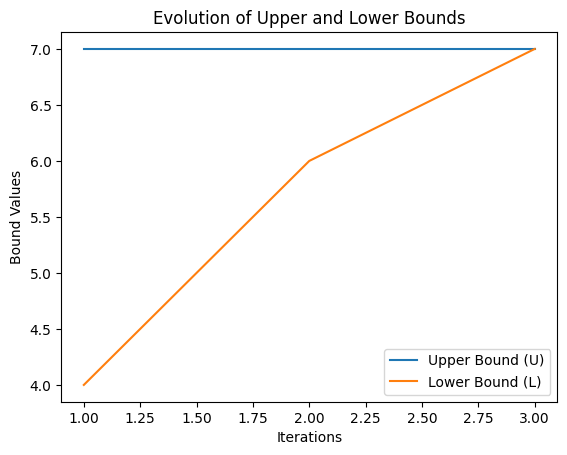

In [15]:
import pycosat
import random
import matplotlib.pyplot as plt

# Paramètres d'initialisation
nClause = 4
nVariable = 3
length = 2
maxNumber = 3

# Génération de la base de connaissance
gen = Generate(nClause, nVariable, length, maxNumber)
gen.generateBC()

# Initialisation de la base de connaissance
baseConnaissance = Process('./base_de_connaissance.txt')
gen_base = gen.getEvidence()
baseConnaissance.evidence = gen_base

# Traitement de la base de connaissance
baseConnaissance.sortedWeight()
baseConnaissance.calculateStrates()

iteration = 1
upper_bounds = []
lower_bounds = []

# Boucle d'itération
while baseConnaissance.lower < baseConnaissance.upper:
    print(f"Iteration = {iteration}")

    # Calcul de r
    r = int((baseConnaissance.lower + baseConnaissance.upper + 1) / 2)

    # Détection de toutes les formules de la strate r
    liste = baseConnaissance.getWeights()
    valueR = -1

    # Détection des indices des formules associées aux strates r et u
    for i in range(len(liste)):
        if baseConnaissance.getStratesWeights()[r - 1] > liste[i]:
            valueR = i
            break
    if valueR == -1:
        valueR = len(liste) - 1

    # Détection des formules de la strate u
    for j in range(len(liste)):
        if baseConnaissance.getStratesWeights()[baseConnaissance.upper - 1] == liste[j]:
            valueU = j
            break

    # cnf contient les formules situées entre les strates u et r pour optimiser l'algorithme de recherche
    cnf = baseConnaissance.formulas[valueU:valueR]

    # Génération de la négation de l'évidence absurde
    for i in range(len(gen_base)):
        literal = -1 * gen_base[i]
        cnf.append([literal])

    cnf = baseConnaissance.getPreProcessedFormulas(cnf)
    print("CNF = ", cnf)

    # Test de la consistence
    result = pycosat.solve(cnf)

    # Mise à jour de la borne supérieure ou inférieure
    if type(result) == type([]):
        baseConnaissance.upper = r - 1
        upper_bounds.append(baseConnaissance.upper)
        print(f"Upper U : {baseConnaissance.upper}")
    else:
        baseConnaissance.lower = r
        lower_bounds.append(baseConnaissance.lower)
        upper_bounds.append(baseConnaissance.upper)  # Ajout de la borne supérieure uniquement lorsque la borne inférieure est mise à jour
        print(f"Lower L : {baseConnaissance.lower}")

    iteration += 1
    print("")

# La valeur associée à la strate correspondant à la borne supérieure
Val = baseConnaissance.getStratesWeights()[r - 1]
print(f"Val({gen_base}, BC) = {Val}")

# Tracé des bornes supérieure et inférieure au fil des itérations
plt.plot(range(1, iteration), upper_bounds, label='Upper Bound (U)')
plt.plot(range(1, iteration), lower_bounds, label='Lower Bound (L)')
plt.xlabel('Iterations')
plt.ylabel('Bound Values')
plt.title('Evolution of Upper and Lower Bounds')
plt.legend()
plt.show()